## Wykrywanie naczyń dna siatkówki oka

__Autorzy:__
 - Kacper Magnuszewski 151746, kacper.magnuszewski@student.put.poznan.pl
 - Tymoteusz Jagła 151811, tymoteusz.jagla@student.put.poznan.pl 

### Cel projektu
Napisany program ma za zadanie wykryć naczynia dna siatkówki oka na zdjęciu, po czym binarnie sklasyfikować każdy piksel zdjęcia (przedstawia żyłkę lub nie) w celu stworzenia maski. Maska ma określić położenie i bieg naczynek na dnie siatkówki. 

### Zastosowany język programowania i biblioteki
 Wykorzystany przez nas język programowania to Python. Projekt napisany jest przy użyciu interaktywnego Jupyter Notebook'a. 

 Do tego użyliśmy bibliotek:
   - OpenCV - Wczytanie i modyfikacja zdjęć
   - numpy - Obliczenia z wykorzystaniem tablic
   - matplotlib - Wyświetlenie zdjęć i efektów przetwarzania na wykresach
   - scikit-image - Filtrowanie i przetwarzanie zdjęcia

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import skimage.exposure as exp
import skimage.filters as filter
import os
import skimage.color as color
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

mplt.rcParams['figure.figsize'] = [20, 12]

### Wczytanie obrazu
Stworzyliśmy klasę Image, w której przechowujemy oryginalne zdjęcie, maskę z ręcznie oznaczonymi naczynkami, pole widzenia oddzielające obraz oka od tła oraz zdjęcie ze zmodyfikowanym parametrem gamma w celu lepszego wyróżnienia żyłek (rozjaśnienie tła, przyciemnienie naczynek).

In [20]:
IMAGE_PATHS = ["images/01_h.jpg", "images/02_h.jpg", "images/03_h.jpg", "images/04_h.jpg", "images/05_h.jpg", "images/06_h.jpg", "images/07_h.jpg", "images/08_h.jpg", "images/09_h.jpg", "images/10_h.jpg", "images/11_h.jpg", "images/12_h.jpg", "images/13_h.jpg", "images/14_h.jpg", "images/15_h.jpg"]
LABELED_PATHS = ["manual/01_h.tif", "manual/02_h.tif", "manual/03_h.tif", "manual/04_h.tif", "manual/05_h.tif", "manual/06_h.tif", "manual/07_h.tif", "manual/08_h.tif", "manual/09_h.tif", "manual/10_h.tif", "manual/11_h.tif", "manual/12_h.tif", "manual/13_h.tif", "manual/14_h.tif", "manual/15_h.tif"]
FOV_PATHS = ["fovmasks/01_h_mask.tif",  "fovmasks/02_h_mask.tif",  "fovmasks/03_h_mask.tif",  "fovmasks/04_h_mask.tif", "fovmasks/05_h_mask.tif", "fovmasks/06_h_mask.tif", "fovmasks/07_h_mask.tif", "fovmasks/08_h_mask.tif", "fovmasks/09_h_mask.tif", "fovmasks/10_h_mask.tif", "fovmasks/11_h_mask.tif", "fovmasks/12_h_mask.tif", "fovmasks/13_h_mask.tif", "fovmasks/14_h_mask.tif", "fovmasks/15_h_mask.tif"]


class Image:
    def __init__(self, image, gammaCorrected, labeled, fov):
        self.image = image
        self.gammaCorrected = gammaCorrected
        self.labeled = labeled
        self.fov = fov


def read_single_image(imagePath, labeledPath, fovPath):
    if not os.path.exists(imagePath):
        raise ValueError(f"The path is not valid: {imagePath}")
    if not os.path.exists(labeledPath):
        raise ValueError(f"The path is not valid: {labeledPath}")
    if not os.path.exists(fovPath):
        raise ValueError(f"The path is not valid: {fovPath}")
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gamma_corrected = exp.adjust_gamma(image, 1.1)
    image_labeled = cv2.imread(labeledPath, cv2.IMREAD_GRAYSCALE)
    image_labeled[np.where(image_labeled > 0)] = 1
    image_fov = cv2.imread(fovPath, cv2.IMREAD_GRAYSCALE)

    return Image(image, image_gamma_corrected, image_labeled, image_fov)

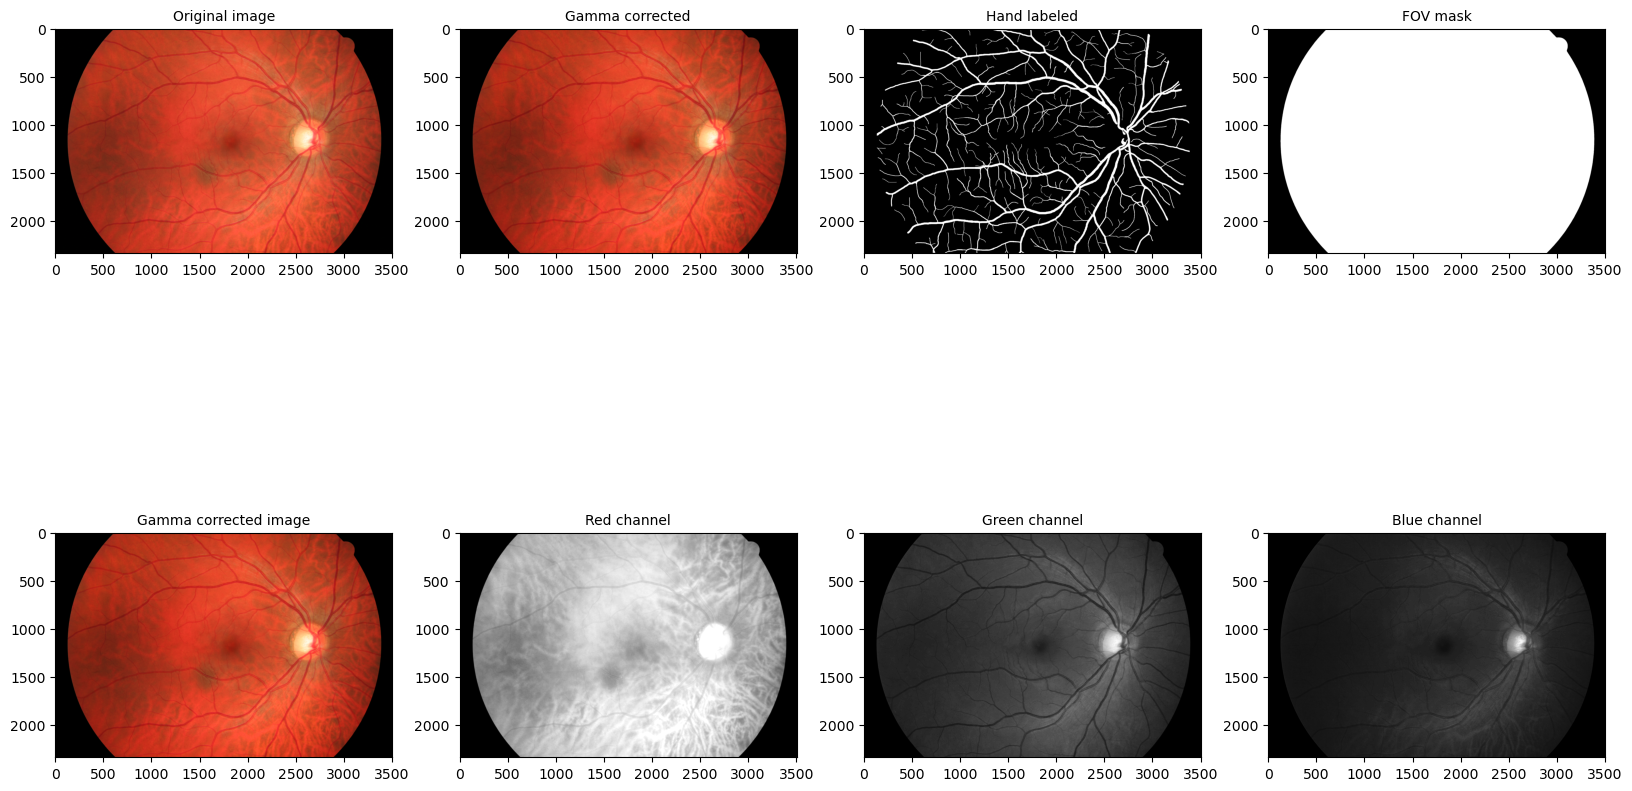

In [21]:
images = []

for image_path, labeled_path, fov_path in zip(IMAGE_PATHS, LABELED_PATHS, FOV_PATHS):
    images.append(read_single_image(image_path, labeled_path, fov_path))

image = images[0].image
image_gamma_corrected = images[0].gammaCorrected
image_labeled = images[0].labeled
image_fov = images[0].fov

image_red = image_gamma_corrected[:, :, 0]
image_green = image_gamma_corrected[:, :, 1]
image_blue = image_gamma_corrected[:, :, 2]

fig, ax = plt.subplots(2, 4)
ax[0][0].set_title("Original image", fontdict = {'fontsize': 10})
ax[0][1].set_title("Gamma corrected", fontdict = {'fontsize': 10})
ax[0][2].set_title("Hand labeled", fontdict = {'fontsize': 10})
ax[0][3].set_title("FOV mask", fontdict = {'fontsize': 10})
ax[0][0].imshow(image)
ax[0][1].imshow(image_gamma_corrected)
ax[0][2].imshow(image_labeled, cmap = "gray")
ax[0][3].imshow(image_fov, cmap = "gray")

ax[1][0].set_title("Gamma corrected image", fontdict = {'fontsize': 10})
ax[1][1].set_title("Red channel", fontdict = {'fontsize': 10})
ax[1][2].set_title("Green channel", fontdict = {'fontsize': 10})
ax[1][3].set_title("Blue channel", fontdict = {'fontsize': 10})
ax[1][0].imshow(image_gamma_corrected)
ax[1][1].imshow(image_red, cmap = "gray")
ax[1][2].imshow(image_green, cmap = "gray")
ax[1][3].imshow(image_blue, cmap = "gray")

### Przetwarzanie obrazu
Następnym krokiem w przetwarzaniu obrazu było przefiltrowanie go w celu odróżnienia naczynek od tła obrazu. W tym celu najpierw zastosowaliśmy filtr Frangi'ego. Nie dał on jednak porządanych efektów. W naszym przypadku nie oddzielał skutecznie tła od naczynek nawet przy modyfikacji parametru gamma zdjęcia. Postanowiliśmy użyć fitra Sato, który dał dużo lepsze efekty w odróżnianiu naczynek od tła. Następnie wygenerowaliśmy maskę zdjęcia stodując odpowiednie progi, dzięki którym określaliśmy czy dany piksel przedstawia naczynko, tło, czy zakłócenie w działaniu filtra. Dodatkowo usunęliśmy obramówkę zdjęcia przyrównując ją do wcześniej zapisanego w klasie pola widzenia.

In [22]:
def filterImage(image):
    filtered = filter.sato(image)

    min_val = np.min(filtered)
    max_val = np.max(filtered)
    filtered = (filtered - min_val) / (max_val - min_val)

    return filtered


def equalize(image):
    equalized = exp.equalize_adapthist(image)
    
    return equalized


def generateMask(image, fov):
    generated_mask = np.zeros(image.shape)
    generated_mask[np.where(image > filter.threshold_local(image, block_size = 3, method = 'mean'))] = 1
    generated_mask[np.where(image < filter.threshold_mean(image) * 2)] = 0
    generated_mask[np.where(fov == 0 )] = 0

    return generated_mask

### Przedstawienie wyników
Poniżej przedstawiliśmy każdy krok przetwarzania obrazu w celu oznaczenia na nim naczynek. Najpierw zostało pokazane zdjęcie po nałożeniu filtra i znormalizowaniu. Następnie uzyskany obraz rozjaśniliśmy, a z niego wygenerowaliśmy maskę. Ostatnie dwa zdjęcia przedstawiają ręcznie oznaczone żyłki dla porównania z maską wygenerowaną przez program oraz efekt końcowy przetwarzania, czyli oryginalne zdjęcie z nałożoną stworzoną maską.

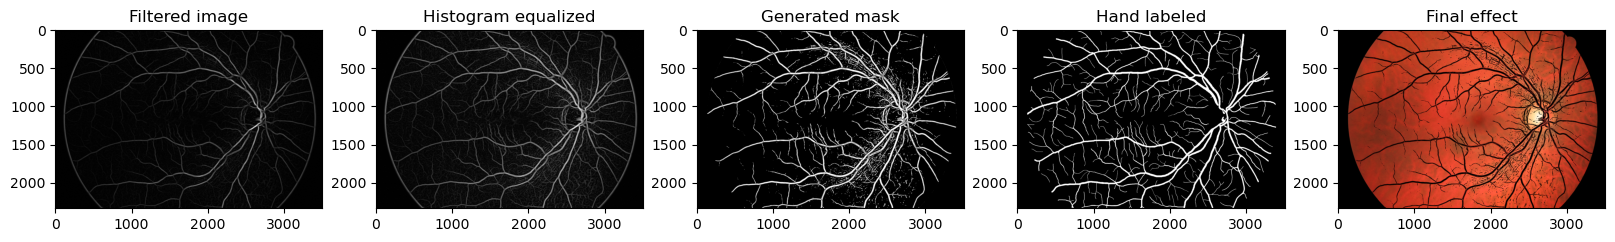

In [ ]:
filtered = filterImage(image_green)
plt.subplot(151)
plt.title("Filtered image")
plt.imshow(filtered, cmap="gray");

equalized = equalize(filtered)
plt.subplot(152)
plt.title("Histogram equalized")
plt.imshow(equalized, cmap="gray")

generated_mask = generateMask(equalized, image_fov)
plt.subplot(153)
plt.title("Generated mask")
plt.imshow(generated_mask, cmap="gray");

plt.subplot(154)
plt.title("Hand labeled")
plt.imshow(image_labeled, cmap = "gray")

image_final = image
image_final[np.where(generated_mask == 1)] = 0
plt.subplot(155)
plt.title("Final effect")
plt.imshow(image_final)

### Badanie poprawności algorytmu
Na koniec przyrównaliśmy wyniki działania naszego programu do maski z ręcznie oznaczonymi naczynkami i dokonaliśmy testów:
  - Trafność (Accuracy)
  - Czułość (Sensitivity)
  - Swoistość (Specificity)

Dodatkowo wyznaczyliśmy dwie macierze przedstawiające wszystkie piksele oznaczone fałszywie ujemnie i fałszywie dodatnio.

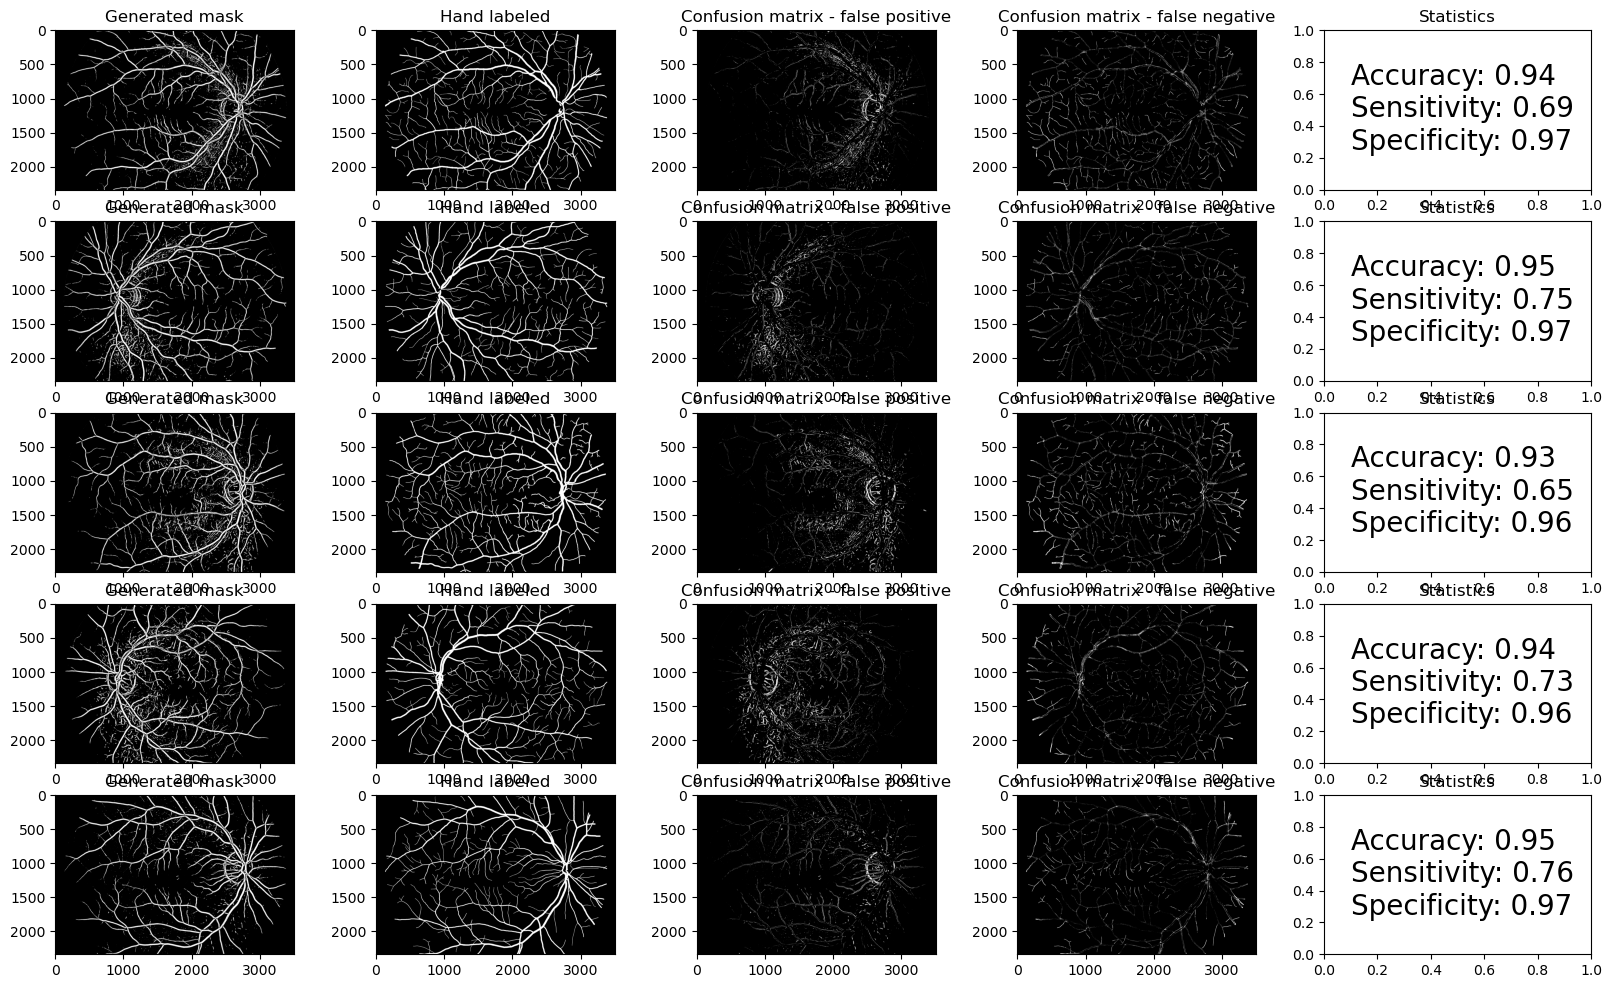

In [23]:
testObjects = 5

fig, axs = plt.subplots(5, 5)
generated_masks = []

for image in images[:testObjects]:
    generated_masks.append((generateMask(equalize(filterImage(image.image[:, :, 1])), image.fov), image.labeled, image.fov))

for i, maskTuple in enumerate(generated_masks):
    mask, labeled, fov = maskTuple
    confusion_matrix_fp = np.zeros(mask.shape)
    confusion_matrix_fn = np.zeros(mask.shape)
    confusion_matrix_fp[np.where(mask > labeled)] = 1
    confusion_matrix_fn[np.where(mask < labeled)] = 1

    true_positive = np.sum(labeled[np.where(mask == 1)] == 1)
    true_negative = np.sum(labeled[np.where(mask == 0)] == 0)
    false_positive = np.sum(labeled[np.where(mask == 1)] == 0)
    false_negative = np.sum(labeled[np.where(mask == 0)] == 1)

    accuracy = round((true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative), 2)
    sensitivity = round(true_positive / (true_positive + false_negative + 1), 2)
    specificity = round(true_negative / (false_positive + true_negative + 1), 2)

    axs[i][0].set_title("Generated mask")
    axs[i][0].imshow(mask, cmap = "gray")

    axs[i][1].set_title("Hand labeled")
    axs[i][1].imshow(labeled, cmap = "gray")

    axs[i][2].set_title("Confusion matrix - false positive")
    axs[i][2].imshow(confusion_matrix_fp, cmap = "gray")

    axs[i][3].set_title("Confusion matrix - false negative")
    axs[i][3].imshow(confusion_matrix_fn, cmap = "gray")

    axs[i][4].set_title("Statistics")
    axs[i][4].set(xlim =(0, 1), ylim =(0, 1)) 
    axs[i][4].text(0.1, 0.25, f"Accuracy: {accuracy}\nSensitivity: {sensitivity}\nSpecificity: {specificity}", fontsize = 20)


plt.show()

## Klasyfikator Liniowej Regresji

* Po wstępnym przetworzeniu obrazu należy podzielić go na wycinki (np. 5x5 px) i dla każdej z nich dokonać ekstrakcji cech z obrazu: np. wariancja kolorów, momenty centralne, momenty Hu itp. Wartości te wraz z informacją pochodzącą z maski eksperckiej (decyzja dla środkowego piksela wycinka) stanowić będą zbiór danych wykorzystany do budowy wybranego klasyfikatora, prostszego niż głęboka sieć neuronowa (np. kNN, drzewo lub las decyzyjny, SVM). Należy skorzystać z gotowej implementacji klasyfikatora (np. w bibliotece scikit-learn).
* Z uwagi na ograniczenia pamięciowe konieczne może być ograniczenie rozmiaru zbioru uczącego poprzez losowy wybór punktów (możliwość zastosowania undersampling-u do zrównoważenia rozkładu klas w zbiorze uczącym).
* Zdolności predykcyjne tak opracowanego klasyfikatora należy wstępnie zweryfikować na niezależnym zbiorze testowym hold-out (np. pochodzącym z innej części obrazu lub z innego obrazu).
* Gotowy klasyfikator powinien zostać osadzony w aplikacji, a jego działanie powinno zostać zwizualizowane i przetestowane w taki sam sposób, jak działanie technik przetwarzania obrazu z wymagań podstawowych. 

In [24]:
class Params:
  def __init__(self, package, features):
    self.package = package
    self.features = features
    self.add_labeled()

  def add_labeled(self):
    orig_labeled = self.package.original.labeled
    height, width = orig_labeled.shape
    print("Original shape:", height, width)

    hmod = height % 5
    wmod = width % 5

    padded_labeled = np.pad(orig_labeled, ((0, 5 - hmod), (0, 5 - wmod)), mode='wrap')
    padded_labeled = (padded_labeled > 0)

    padded_labeled = padded_labeled.flatten()
    self.labeled = padded_labeled

class Package:
  def __init__(self, original_img, padded_img, fragments):
    self.original = original_img
    self.padded = padded_img
    self.fragments = fragments

  def __repr__(self):
    original_height, original_width, _ = self.original.shape
    padded_height, padded_width, _ = self.padded.shape
    return f"original_size: {original_height}x{original_width}, padded_size: {padded_height}x{padded_width}, first_fragment {self.fragments[0]}"

In [25]:
def divide_in_fragments(input):
  image = input.image
  frags = []
  height, width, _ = image.shape

  hcount = height // 5
  wcount = width // 5
  hmod = height % 5
  wmod = width % 5

  padded_image = np.pad(image, ((0, 5 - hmod), (0, 5 - wmod), (0, 0)), mode='wrap')

  padded_height, padded_width, _ = padded_image.shape

  for i in range(padded_height):
    for j in range(padded_width):
        # Calculate the start and end coordinates of the fragment including neighbors
        start_row = max(i - 2, 0)
        end_row = min(i + 2 + 1, height)
        start_col = max(j - 2, 0)
        end_col = min(j + 2 + 1, width)

        # Extract the fragment
        fragment = padded_image[start_row:end_row, start_col:end_col]
        frags.append(fragment)

  return Package(input, padded_image, frags)

def wrap_with_params(package):
  features = parallel(package.fragments)

  return Params(package, features)

def parallel(fragments, max_workers = 16):
  results = [None] * len(fragments)

  with ThreadPoolExecutor(max_workers=max_workers) as executor:
      futures = {executor.submit(single, frag): idx for idx, frag in enumerate(fragments)}

      for future in as_completed(futures):
          idx = futures[future]
          try:
              results[idx] = future.result()
          except Exception as exc:
              print(f"Fragment {idx} generated an exception: {exc}")
  return results

def single(frag):
  var_r = np.var(frag[:,:,0])
  var_g = np.var(frag[:,:,1])
  var_b = np.var(frag[:,:,2])

  # get only green channel
  frag[:,:,0] = 0
  frag[:,:,2] = 0
  frag = color.rgb2gray(frag)
  frag_features = cv2.HuMoments(cv2.moments(frag)).flatten()
  frag_features = np.append(frag_features, var_r)
  frag_features = np.append(frag_features, var_g)
  frag_features = np.append(frag_features, var_b)
  return frag_features

# def rescale(image):
#   rescaled = copy.deepcopy(image)  

#   scale = 0.25
#   new_width = int(rescaled.image.shape[1] * scale)
#   new_height = int(rescaled.image.shape[0] * scale)
#   new_size = (new_width, new_height)

#   rescaled.image = cv2.resize(image.image, new_size, interpolation=cv2.INTER_AREA)
#   rescaled.labeled = cv2.resize(image.labeled, new_size, interpolation=cv2.INTER_AREA)

#   print("Image rescaled: ", rescaled.image.shape, rescaled.labeled.shape)
#   return rescaled

# def crop(image):
#   cropped = copy.deepcopy(image)

#   h, w, _ = cropped.image.shape
#   new_height = 800
#   new_width = 1200

#   cropped.image = cropped.image[:new_height, w//2-new_width//2:w//2+new_width//2, :]
#   cropped.labeled = cropped.labeled[:new_height, w//2-new_width//2:w//2+new_width//2]
#   print("Image cropped: ", cropped.image.shape, cropped.labeled.shape)
#   return cropped


In [26]:
imputer = SimpleImputer(strategy='constant', fill_value=0.0)
model = LinearRegression()

In [27]:
testCases = 10
fig, axs = plt.subplots(testObjects, 3)

for i in range(testCases):
    divided = divide_in_fragments(images[i])
    parametrized = wrap_with_params(divided)
    imputer.fit(parametrized.features)
    model.fit(imputer.transform(parametrized.features), parametrized.labeled)

for i in range(testCases, testObjects + testCases):
    divided_test = divide_in_fragments(images[i])
    parametrized_test = wrap_with_params(divided_test)
    predict = model.predict(imputer.transform(parametrized_test.features))

    width, height, _ = parametrized_test.package.padded.shape
    img = np.reshape(predict, (width, height))

    true_positive = np.sum(parametrized_test.labeled[np.where(img == 1)] == 1)
    true_negative = np.sum(parametrized_test.labeled[np.where(img == 0)] == 0)
    false_positive = np.sum(parametrized_test.labeled[np.where(img == 1)] == 0)
    false_negative = np.sum(parametrized_test.labeled[np.where(img == 0)] == 1)

    accuracy = round((true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative), 2)
    sensitivity = round(true_positive / (true_positive + false_negative + 1), 2)
    specificity = round(true_negative / (false_positive + true_negative + 1), 2)

    axs[i][0].set_title("Generated mask")
    axs[i][0].imshow(img, cmap='gray')

    axs[i][1].set_title("Hand labeled")
    axs[i][1].imshow(parametrized_test.labeled, cmap = "gray")

    axs[i][2].set_title("Statistics")
    axs[i][2].set(xlim =(0, 1), ylim =(0, 1)) 
    axs[i][2].text(0.1, 0.25, f"Accuracy: {accuracy}\nSensitivity: {sensitivity}\nSpecificity: {specificity}", fontsize = 20)


KeyboardInterrupt: 